# Simple to Refined (Basitten rafineye(işlenmiş))

Evrişimli ağların üç işlem yoluyla özellik çıkarmayı nasıl gerçekleştiğinden bahsettik: filtreleme, algılama ve yoğunlaştırma. Tek bir özellik çıkarma turu, bir görüntüden yalnızca basit çizgiler veya kontrastlar gibi nispeten basit özellikler çıkarabilir. Bunlar çoğu sınıflandırma problemini çözmek için çok basittir. Bunun yerine, convnet'ler bu çıkarmayı tekrar tekrar yapacaklar, böylece özellikler ağın daha derinlerine indikçe daha karmaşık ve rafine hale gelecek.<br><br>

Bunu, bu çıkarma işlemini gerçekleştiren uzun evrişimsel blok zincirlerinden geçirerek yapar.<br>
Bu evrişim blokları, özellik çıkarmadaki rolünü son birkaç derste öğrendiğimiz Conv2D ve Maxpool2D katmanlarının stackleridir(yığınlarıdır).<br><br>

Her blok bir çıkarma turunu temsil eder ve bu blokları bir araya getirerek, convnet üretilen özellikleri birleştirebilir ve yeniden birleştirebilir, bunları büyütebilir ve eldeki soruna daha iyi uyacak şekilde şekillendirebilir. Modern konvnetlerin derin yapısı, bu karmaşık özellik mühendisliğine izin veren şeydir ve üstün performanslarından büyük ölçüde sorumlu olmuştur.

# Step 1: Load Data

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seed()

# Set Matplotlib Defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

warnings.filterwarnings('ignore') # to clean up output cells

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'datas/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)

ds_valid_ = image_dataset_from_directory(
    'datas/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5051 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


# Step 2: Define Model

Modelimizin Conv2D ve MaxPool2D katmanlarımdan(taban) oluşan ve ardından bir Dense(Yoğun) katman başlığından nasıl oluştuğuna bakalım. Sadece uygun parametreleri doldurarak Keras Sequential modeline çevirebiliriz.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    
    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same',
                 # give the input dimensions in the first layer
                 # [height, width, color, channels(RGB)]
                 input_shape=[128, 128, 3]),
    
    layers.MaxPool2D(),
    
    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation='relu'),
    layers.Dense(units=1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

Filtre sayısının blok blok nasıl ikiye katlandığına dikkat edin: 64, 128, 256. Bu, yaygın bir kalıptır. MaxPool2D katmanı özellik haritalarının boyutunu küçülttüğünden, oluşturduğumuz artırmayı göze alabilirz.

# Step 3: Train

Modelimizi ikili sınıflandırmaya uygun bir kayıp ve metrikle birlikte bir optimize edici ile derleyelim.

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid_,
    # model eğitilirken verilerin tamamı aynı anda eğitime katılmaz. Parçalar halinde katılır.
    # Her adımda başarıma göre geriyayılım ile ağırlıklar güncellenir. Her bir adıma 'epoch' denir.
    epochs=40, 
    verbose=0
)

KeyboardInterrupt: 

<AxesSubplot:>

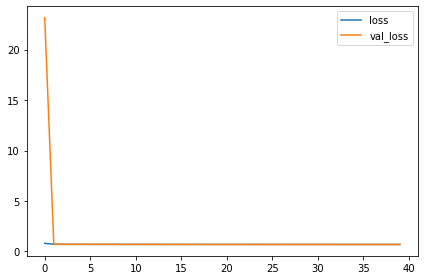

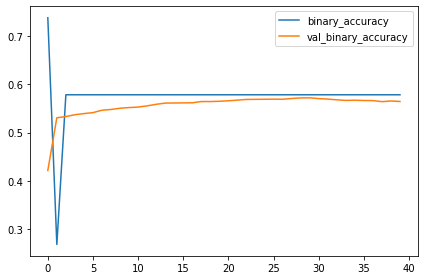

In [8]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()